In [3]:
# Import libraries

import os
import csv

import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from numpy import genfromtxt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization

In [6]:
# Сreate a function that finds all files of a given format in a directory and puts their names in a list

def get_files_names(dir, format='.jpg'):
    file_list = []
    for root, dirs, files in os.walk(dir, topdown=False):
        for name in files:
            if name.endswith(format):
                file_name = os.path.join(root, name)
                file_list.append(file_name)
    return file_list

In [8]:
# Create a function that reads all the image files in the folders, converting each image into an array. At the same time, 
# the corresponding emotion by the name of the directory is added to the target. At the output of the function, there are two 
# datasets - training and test, divided into date and target, which are recorded in 4 files for the possibility of further 
# work with data without re-processing images.

def load_convert_image(sample_name):
    target = pd.DataFrame(columns=['target'])
    
    # load the original image
    file_names_list = get_files_names('C:/Users/Konstantin/Documents/Стажировка Lets Grow More/Task 10/data/' + sample_name)
    
    print(f'Start {sample_name} data loading and converting...')
    for file in file_names_list:
        img_file = Image.open(file)

        # Get original image parameters...
        w, h = img_file.size

        value = np.asarray(img_file.getdata(), dtype=int).reshape((h, w))
        value = value.flatten()

        target.loc[len(target.index)] = file.split('\\')[-2]
    
        with open(sample_name + '_data.csv', 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(value)   

    target.to_csv(sample_name + '_target.csv', index=False)
    print(f'Completed. Loaded and converted {len(target)} files from {sample_name} sample.\n'
          f'Data saved in project directory as files {sample_name}_data.csv and {sample_name}_target.csv ')
    
for directory in ['train', 'test']:
    load_convert_image(directory)

Start train data loading and converting...
Completed. Loaded and converted 28709 files from train sample.
Data saved in project directory as files train_data.csv and train_target.csv 
Start test data loading and converting...
Completed. Loaded and converted 7178 files from test sample.
Data saved in project directory as files test_data.csv and test_target.csv 


In [9]:
# Read the data received as a result of the previous functions. Put the data in numpy arrays, target - in pd.DataFrames

train_data = genfromtxt('train_data.csv', delimiter=',', dtype=int)
test_data = genfromtxt('test_data.csv', delimiter=',', dtype=int)
train_target = pd.read_csv('train_target.csv')
test_target = pd.read_csv('test_target.csv')

In [10]:
# Convert arrays with image data (train_x and test_x)
# Return the original image size from one-dimensional arrays obtained as a result of previous transformations for writing to.csv

train_x = train_data.reshape(train_data.shape[0], int(math.sqrt(train_data.shape[1])), int(math.sqrt(train_data.shape[1])))
test_x = test_data.reshape(test_data.shape[0], int(math.sqrt(test_data.shape[1])), int(math.sqrt(test_data.shape[1])))

# Convert data type to float

train_x = train_x.astype(float)
test_x = test_x.astype(float)

# Add one more dimension to the x array, since the images are one-color, its size is 1

train_x = np.expand_dims(train_x, axis=3)
test_x = np.expand_dims(test_x, axis=3)

# Perform image normalization

train_x = train_x / 255
test_x = test_x / 255

print(f'train_x size: {train_x.shape}\ntest_x size: {test_x.shape}')

train_x size: (28709, 48, 48, 1)
test_x size: (7178, 48, 48, 1)


In [11]:
# Convert the mood names of y using LabelEncoder to numeric values, put y values into numpy array and then transform to binary 
# class matrix

num_classes = train_target.target.nunique()

encoder = LabelEncoder()
train_target.target = encoder.fit_transform(train_target.target)
test_target.target = encoder.transform(test_target.target)

train_y = pd.DataFrame(train_target).to_numpy()
test_y = pd.DataFrame(test_target).to_numpy()

train_y = tf.keras.utils.to_categorical(train_y, num_classes=num_classes)
test_y = tf.keras.utils.to_categorical(test_y, num_classes=num_classes)

print(f'train_y size: {train_y.shape}\ntest_y size: {test_y.shape}')

train_y size: (28709, 7)
test_y size: (7178, 7)


In [23]:
# Create and compiling a Sequential model with six 2D convolution layers, two Dense and Flatten layer. 
# Add a BatchNormalization layer after each layer to make training faster and more stable through 
# normalization of the layers' inputs by re-centering and re-scaling
# Use four dropout layers to reduce overfitting.
# Add 3 layers of subsampling by the maximum value (MaxPooling) after 2, 4 and 6 convolution layers.
# Take categorical_crossentropy as a loss function and accuracy as a metric.

model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())

model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
# Fit model on 60 epochs with a batch size of 128 and save the model. 

hist = model.fit(train_x, train_y, batch_size = 128, epochs=60, verbose=1, validation_data=(test_x, test_y))
#model.save('facial_recognition.h5')

Epoch 1/60
225/225 [==============================] - 10s 40ms/step - loss: 2.4040 - accuracy: 0.2184 - val_loss: 1.8486 - val_accuracy: 0.2471
Epoch 2/60
225/225 [==============================] - 9s 39ms/step - loss: 1.8643 - accuracy: 0.3098 - val_loss: 1.7168 - val_accuracy: 0.2924
Epoch 3/60
225/225 [==============================] - 9s 39ms/step - loss: 1.6785 - accuracy: 0.3606 - val_loss: 1.5241 - val_accuracy: 0.4019
Epoch 4/60
225/225 [==============================] - 9s 39ms/step - loss: 1.5439 - accuracy: 0.4062 - val_loss: 1.5333 - val_accuracy: 0.4121
Epoch 5/60
225/225 [==============================] - 9s 39ms/step - loss: 1.4524 - accuracy: 0.4437 - val_loss: 1.3893 - val_accuracy: 0.4656
Epoch 6/60
225/225 [==============================] - 9s 39ms/step - loss: 1.4014 - accuracy: 0.4646 - val_loss: 1.3440 - val_accuracy: 0.4875
Epoch 7/60
225/225 [==============================] - 9s 39ms/step - loss: 1.3580 - accuracy: 0.4823 - val_loss: 1.2800 - val_accuracy: 0.507

Epoch 58/60
225/225 [==============================] - 9s 39ms/step - loss: 0.7935 - accuracy: 0.7129 - val_loss: 1.0040 - val_accuracy: 0.6434
Epoch 59/60
225/225 [==============================] - 9s 39ms/step - loss: 0.7945 - accuracy: 0.7155 - val_loss: 1.0685 - val_accuracy: 0.6244
Epoch 60/60
225/225 [==============================] - 9s 39ms/step - loss: 0.7859 - accuracy: 0.7142 - val_loss: 1.0273 - val_accuracy: 0.6415


In [26]:
# Print model loss/metric

score = model.evaluate(test_x, test_y, verbose=0)

print('test loss:', round(score[0], 4))
print('test accuracy:', round(score[1], 4))

test loss: 1.0273
test accuracy: 0.6415


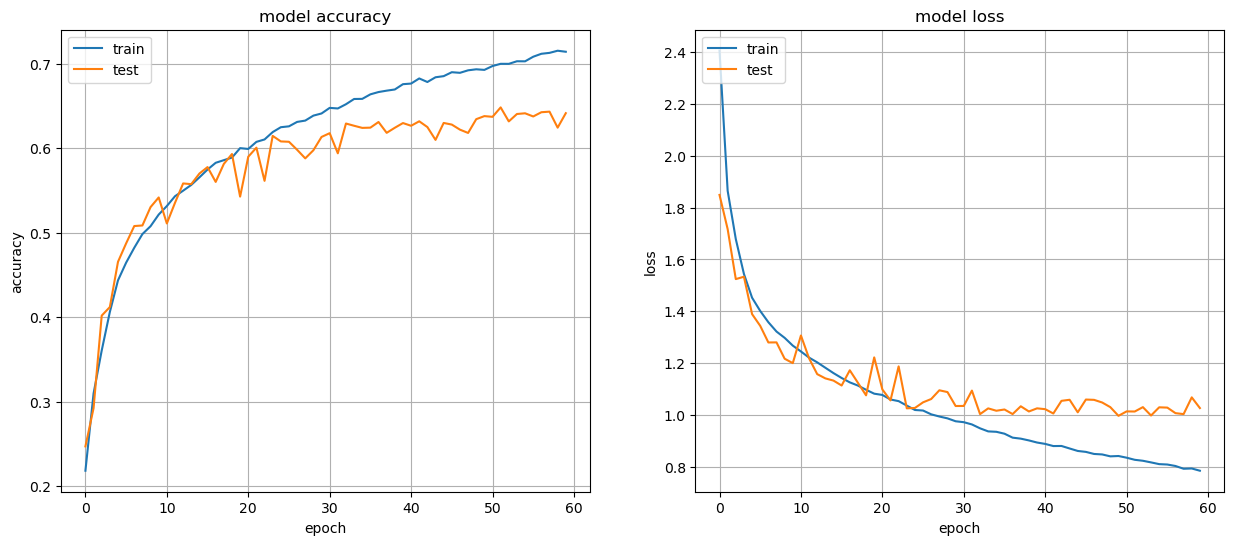

In [35]:
# Visualize history for accuracy metric and for loss

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].plot(hist.history['accuracy'])
ax[0].plot(hist.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')
ax[0].grid();

ax[1].plot(hist.history['loss'])
ax[1].plot(hist.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='upper left')
ax[1].grid();

In [36]:
# Get the prediction probability using the model, then get the class prediction from it and apply the inverse transformation 
# to them with the LabelEncoder.

y_proba = model.predict(test_x, verbose = 0)
y_pred = np.empty((0, 1))
for i in range(0, len(y_proba)):
    y_pred = np.append(y_pred, np.argmax(y_proba[i]))
y_pred = y_pred.astype(int)
y_pred = encoder.inverse_transform(y_pred)

# Similarly, apply the inverse transformation for test_y
y_test = np.empty((0, 1))
for i in range(0, len(test_y)):
    y_test = np.append(y_test, np.argmax(test_y[i]))
y_test = y_test.astype(int)
y_test = encoder.inverse_transform(y_test)

In [37]:
# Print report on the metrics for each of the classes

labels = np.unique(y_test).tolist()
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

       angry       0.61      0.52      0.56       958
     disgust       0.70      0.53      0.61       111
        fear       0.51      0.34      0.41      1024
       happy       0.83      0.86      0.84      1774
     neutral       0.57      0.67      0.61      1233
         sad       0.49      0.55      0.52      1247
    surprise       0.72      0.82      0.77       831

    accuracy                           0.64      7178
   macro avg       0.63      0.61      0.62      7178
weighted avg       0.64      0.64      0.63      7178



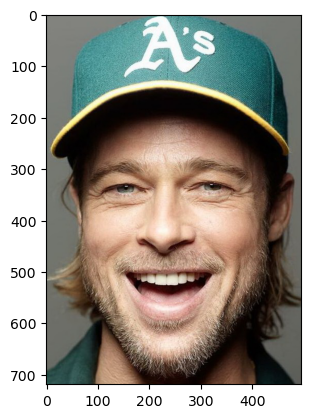

In [38]:
# Make a prediction for a random picture from the Internet, let it be a photo of Brad Pitt :-)

img = Image.open('bredpit.jpg')
plt.imshow(img)
plt.show();

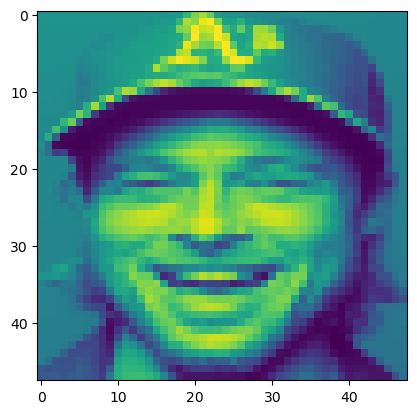

In [40]:
# Convert the image to numpy array with a single color channel and resize according to the shape of the model input

x = np.asarray(img.convert('L'))
x = cv2.resize(x, (48, 48), interpolation=cv2.INTER_AREA)
plt.imshow(x) 
plt.show();

In [41]:
# Convert data type to float
x = x.astype('float32')
# Add two dimensions to the x array. Since array contain only one image and the image are one-color, size of dimensions is 1
x = np.expand_dims(x, axis=2)
x = np.expand_dims(x, axis=0)
# Perform image normalization
x = x / 255

print(f'x size: {x.shape}, x type: {x.dtype}')

x size: (1, 48, 48, 1), x type: float32


In [42]:
# Executing a predict using model
prediction = model.predict(x, verbose = 0)
prediction = [np.argmax(prediction)]
# Apply the reverse transformation with the LabelEncoder.
pred_encoded = encoder.inverse_transform(prediction)[0]
prediction = prediction[0]

In [44]:
# Will recommend Brad Pitt a track that suits his mood :-) 
# Let it be a track from a site that recommends music by categories for mood

link = 'http://inmood.ru/mood/'
print(f'This person looks {pred_encoded}!\nI think it is what he needs now! Listen to one of these tracks:')

if prediction == 0: # angry
    print(f'{link}angry/ , for example "Violence — Dope"')
elif prediction == 1: # disgust
    print(f'{link}rebel/ , for example "Metallica — Die Die My Darling"')
elif prediction == 2: # fear
    print(f'{link}worried/ , for example "Lux Aeterna — Clint Mansell Feat. Krono"')
elif prediction == 3: # happy
    print(f'{link}happy/ , for example "Safe And Sound — Capital Cities"')
elif prediction == 4: # neutral
    print(f'{link}calm/ , for example "Im Not The Only One — Sam Smith"')
elif prediction == 5: # sad
    print(f'{link}sad/ , for example "Black Black Heart — David Usher"')
else: # surprise
    print(f'{link}positive/ , for example "I Got You (I Feel Good) — James Brown"')

This person looks happy!
I think it is what he needs now! Listen to one of these tracks:
http://inmood.ru/mood/happy/ , for example "Safe And Sound — Capital Cities"
